In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

import os
from keras.applications.vgg16 import VGG16

In [ ]:
print(os.listdir("/content/drive/MyDrive/ml"))

['validation', 'train']


In [ ]:
SIZE = 256

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_images = []
train_labels = []

In [ ]:
for directory_path in glob.glob("/content/drive/MyDrive/ml/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)

/content/drive/MyDrive/ml/train/BCC
/content/drive/MyDrive/ml/train/HEALTHY
/content/drive/MyDrive/ml/train/SCC
/content/drive/MyDrive/ml/train/IEC


In [ ]:
for directory_path in glob.glob("/content/drive/MyDrive/ml/train/*"):
    fruit_label = os.path.basename(directory_path)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional
        train_images.append(img)
        train_labels.append(fruit_label)

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
train_images.shape

(320, 256, 256, 3)

In [ ]:
train_labels.shape

(320,)

In [ ]:
test_images = []
test_labels = []

In [ ]:
for directory_path in glob.glob("/content/drive/MyDrive/ml/validation/*"):
    fruit_label_new = os.path.basename(directory_path)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional
        test_images.append(img)
        test_labels.append(fruit_label_new)

In [ ]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
np.unique(train_labels)

array(['BCC', 'HEALTHY', 'IEC', 'SCC'], dtype='<U7')

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
print(np.unique(train_labels_encoded))

[0 1 2 3]


In [ ]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
 #Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False

VGG_model.summary()  #Trainable parameters will be 0

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
#Now, let us use features from convolutional network for RF
#generates a feature map for X_train images
feature_extractor=VGG_model.predict(x_train)
#flattens the feature map into a 1D array.
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

10/10 [==============================] - 277s 28s/step


In [ ]:

X_for_training.shape

(320, 32768)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=1)

In [ ]:
neigh.fit(X_for_training, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

3/3 [==============================] - 72s 23s/step


In [ ]:
#Now predict using the trained RF model.
prediction = neigh.predict(X_test_features)
#Inverse le transform to get original label back.
prediction = le.inverse_transform(prediction)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.6818181818181818


<Axes: >

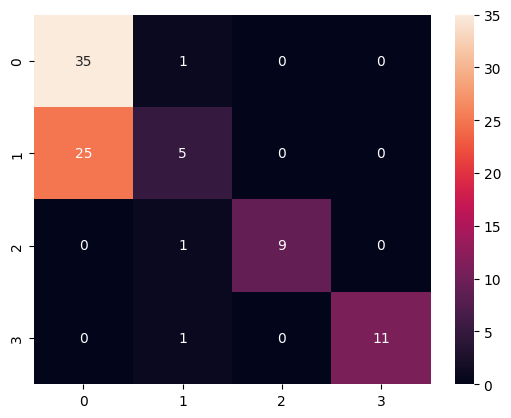

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,prediction))

              precision    recall  f1-score   support

         BCC       0.58      0.97      0.73        36
     HEALTHY       0.62      0.17      0.26        30
         IEC       1.00      0.90      0.95        10
         SCC       1.00      0.92      0.96        12

    accuracy                           0.68        88
   macro avg       0.80      0.74      0.72        88
weighted avg       0.70      0.68      0.63        88



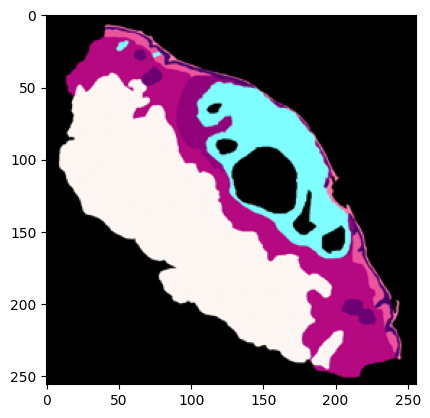

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)


In [ ]:
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = neigh.predict(input_img_features)[0]
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

1/1 [==============================] - 1s 723ms/step
The prediction for this image is:  ['BCC']
The actual label for this image is:  BCC
